In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from nam.wrapper import NAMClassifier
import sklearn.metrics as sk_metrics
import seaborn as sns
from scipy.stats import gaussian_kde

c:\Users\arthe\anaconda3\envs\scbert_new\lib\site-packages\nam\trainer\trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
#load data
X = pd.read_csv('data/data_preprocessed.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('data/test_data_preprocessed.csv').drop('Unnamed: 0', axis=1)
y = pd.read_csv('data/outcome.csv')['HeartDisease']
y_test = pd.read_csv('data/outcome_test.csv')['HeartDisease']

In [4]:
random_state = 2016
NUMBER_OF_LEARNERS = 5
model = NAMClassifier(
            num_epochs=50,
            num_learners=NUMBER_OF_LEARNERS,
            metric='auroc',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=10,
            random_state=random_state
        )

model.fit(X, y)

In [ ]:
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [12]:
X_test.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
       'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'FastingBS_0', 'FastingBS_1', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [30]:
X_test['Sex'].describe()

count    184.000000
mean       0.109794
std        0.918477
min       -1.886533
25%        0.530073
50%        0.530073
75%        0.530073
max        0.530073
Name: Sex, dtype: float64

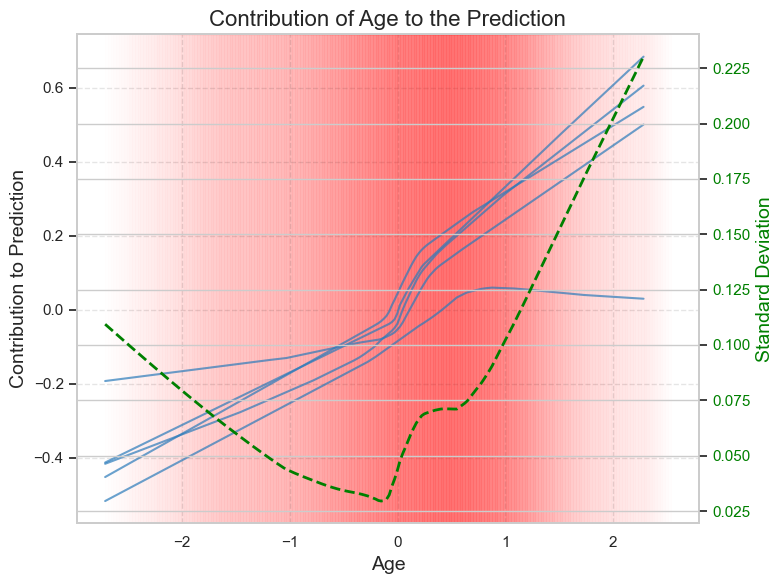

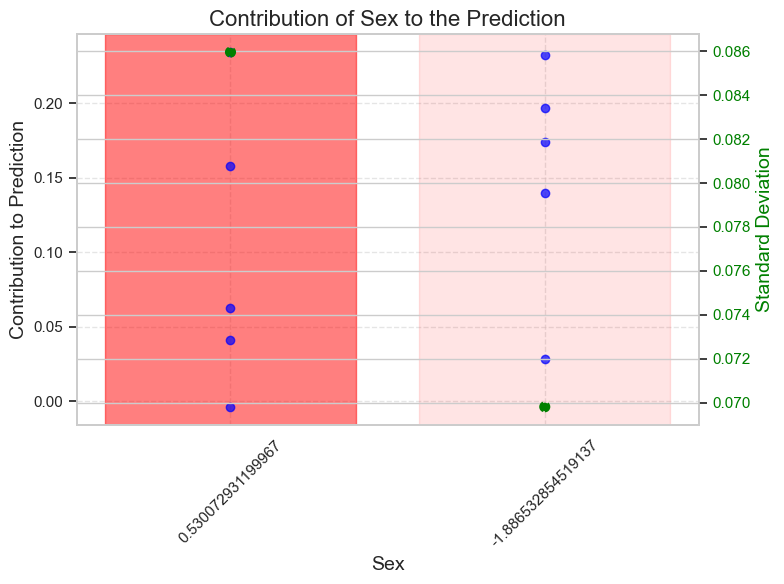

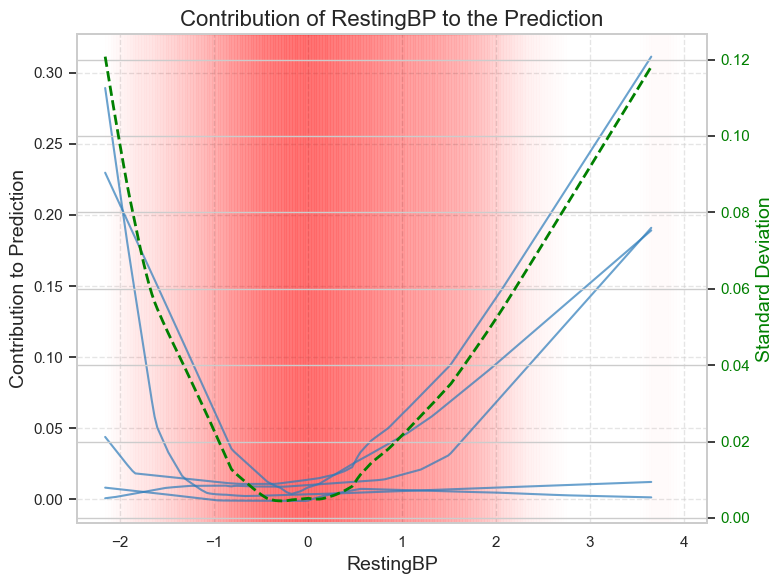

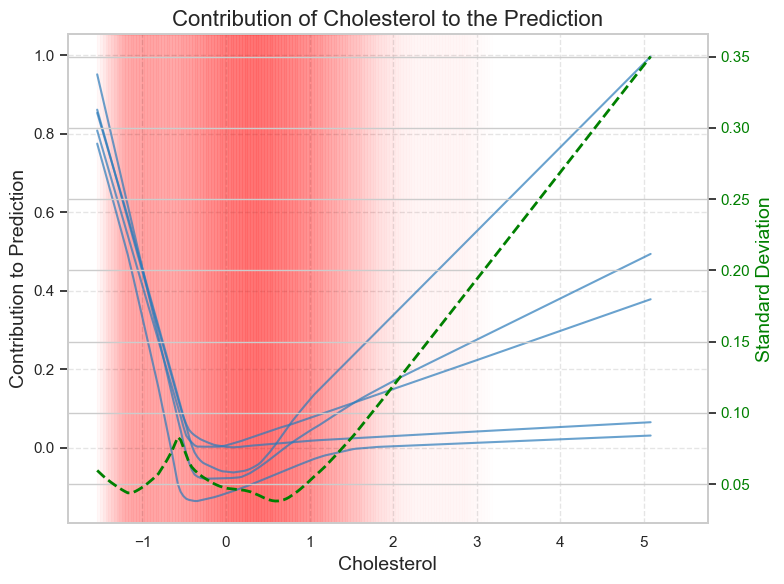

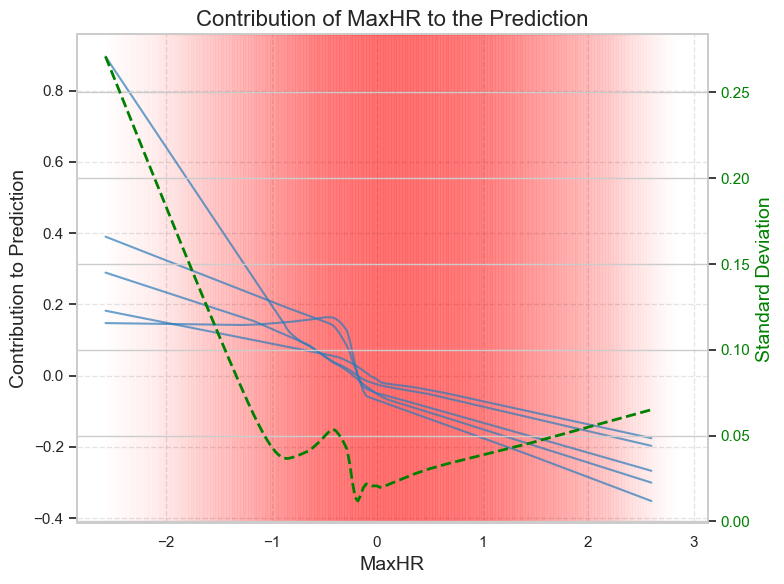

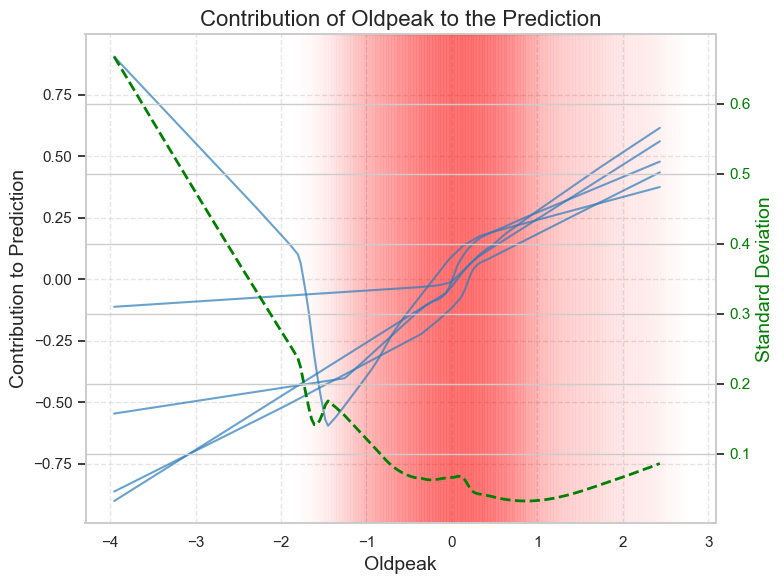

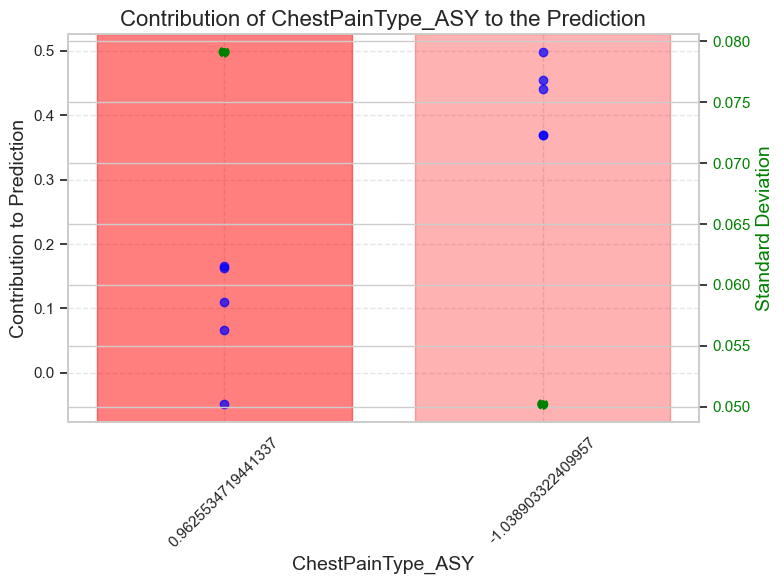

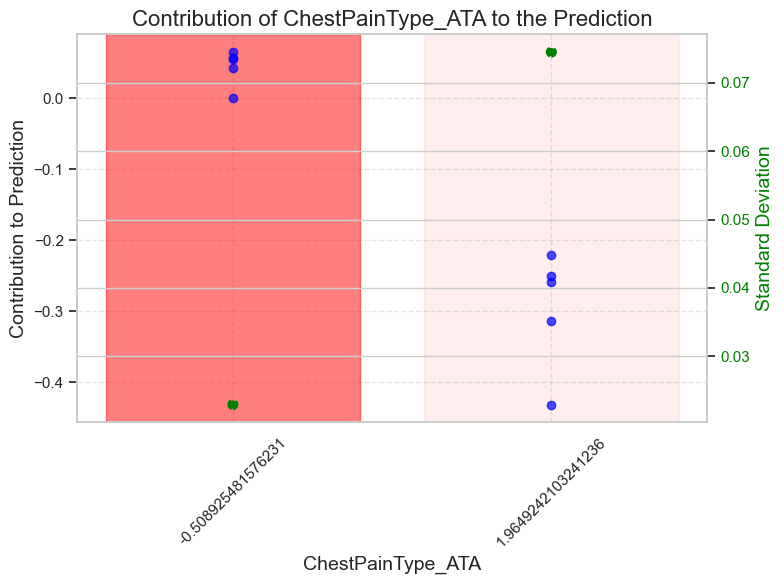

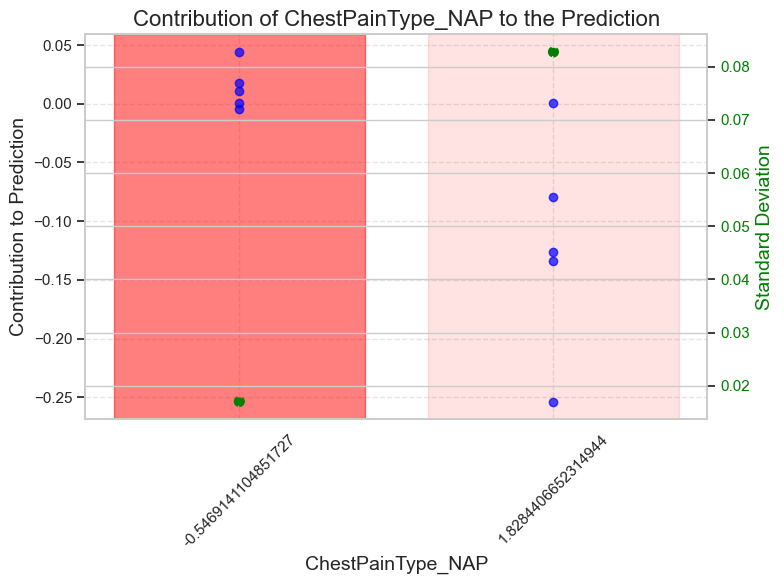

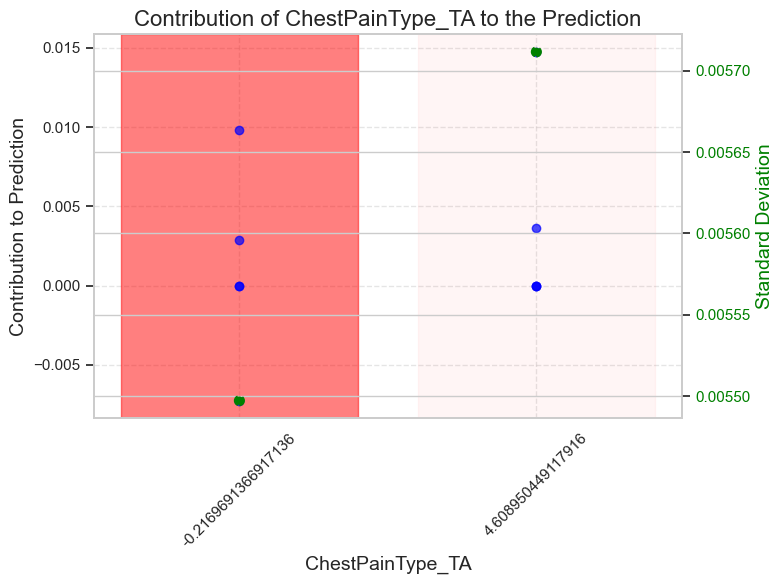

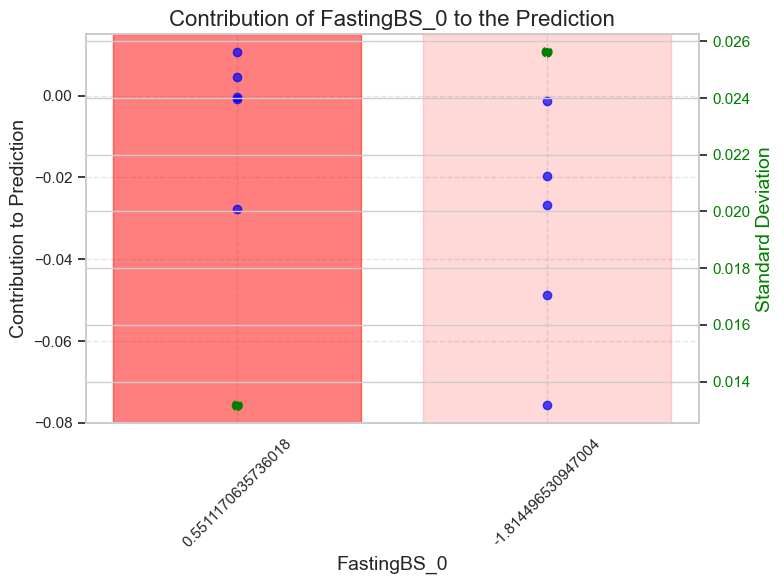

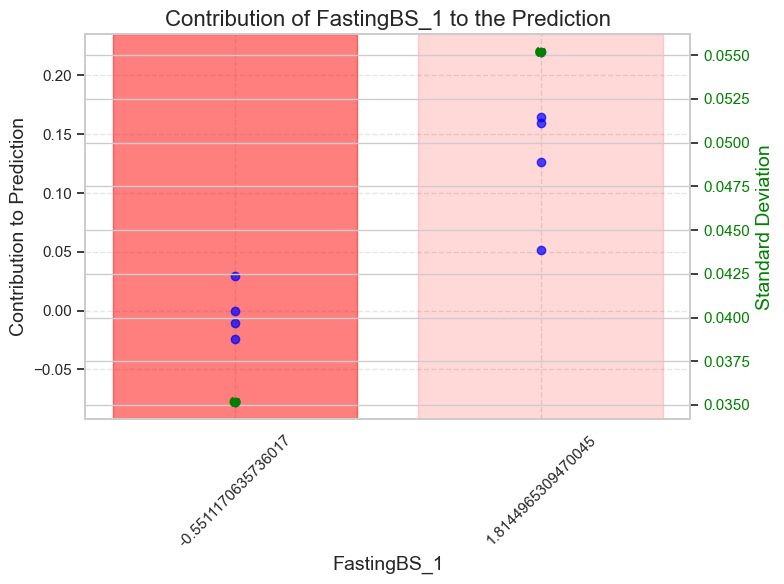

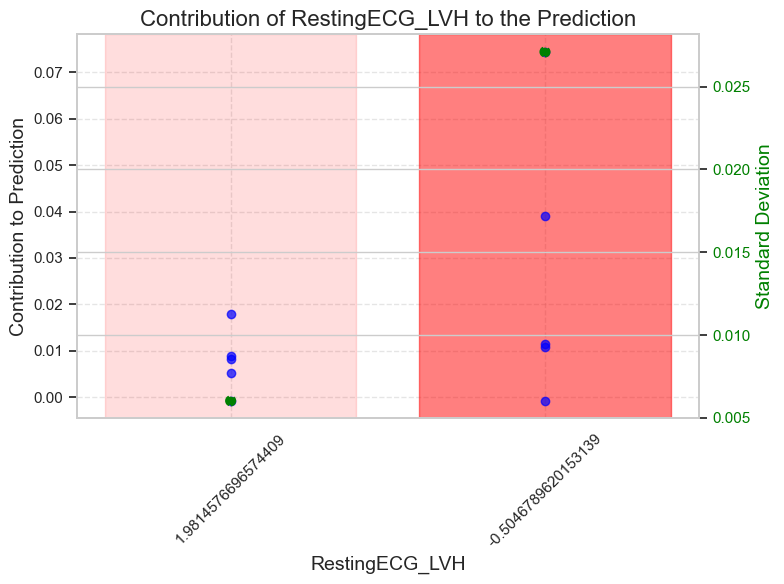

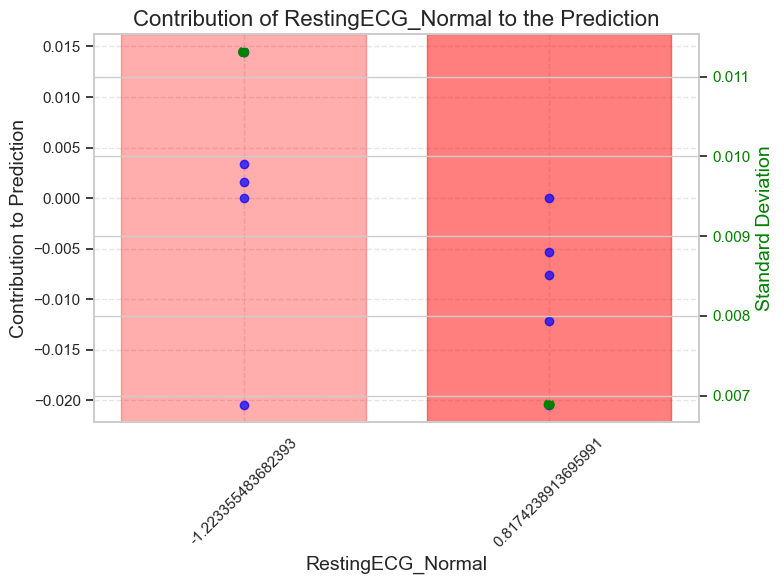

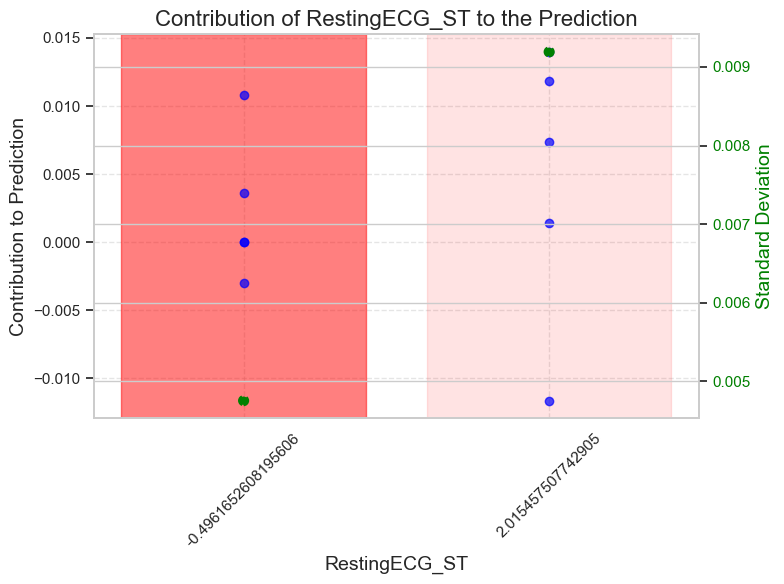

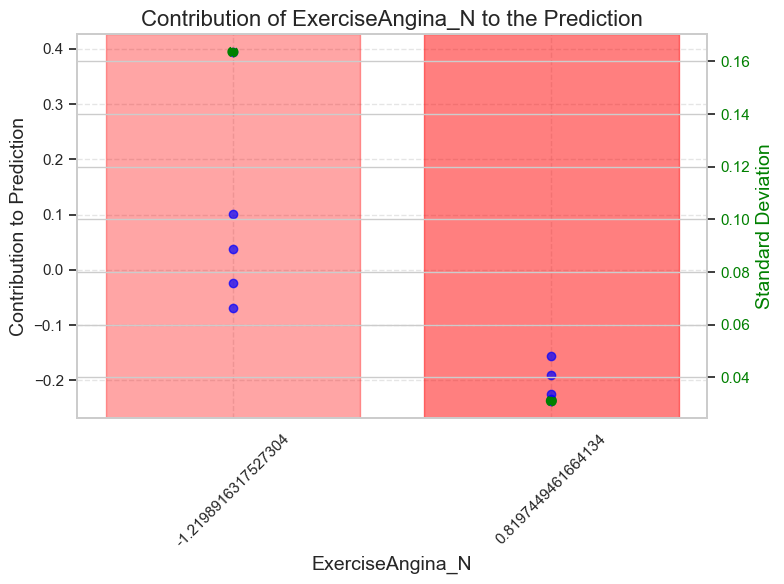

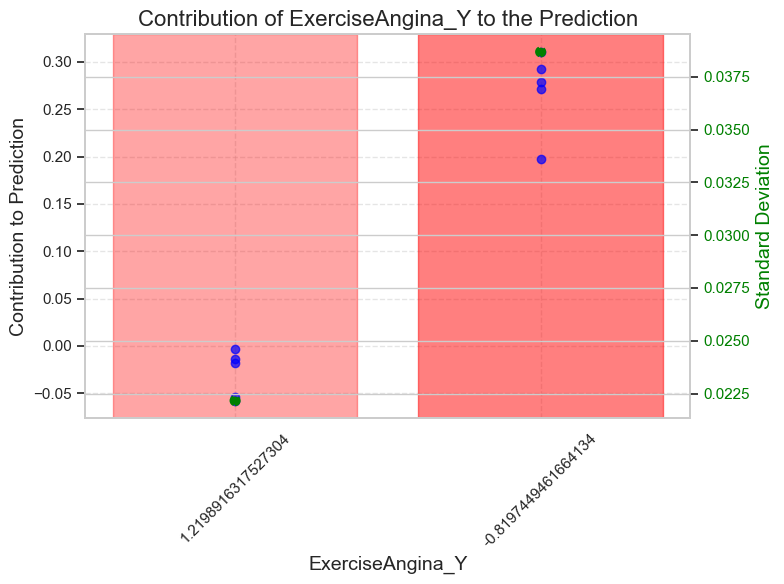

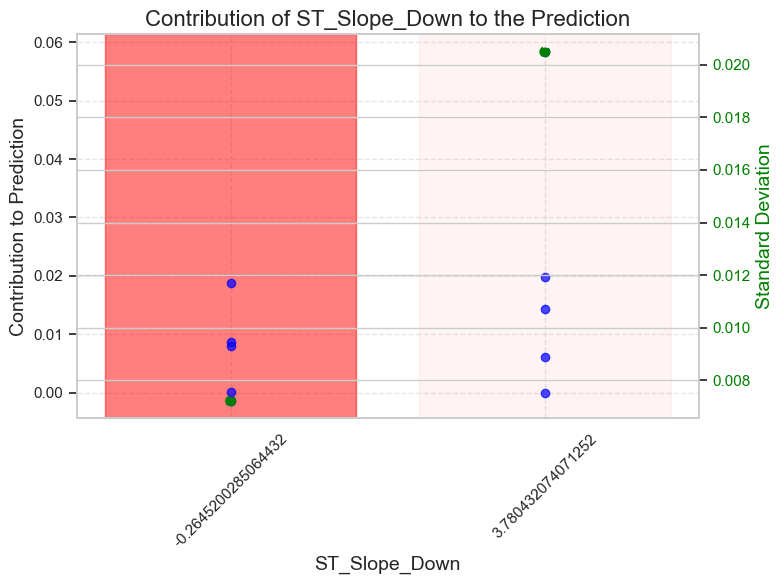

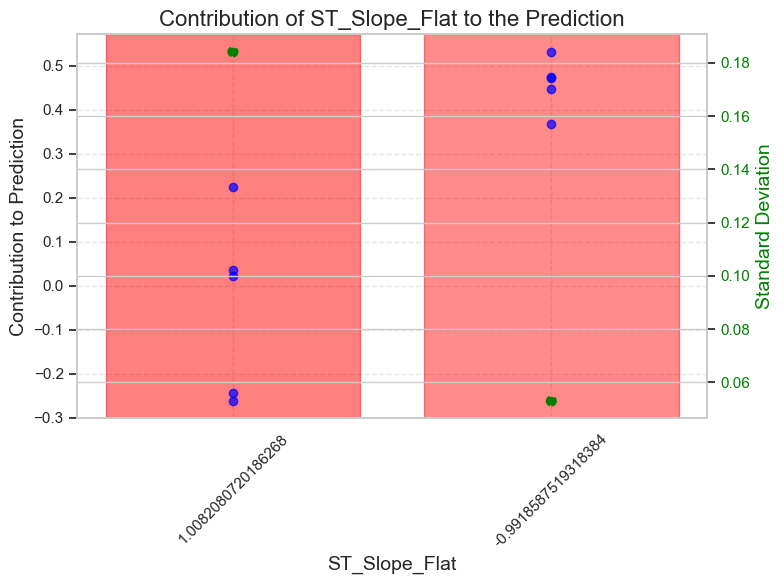

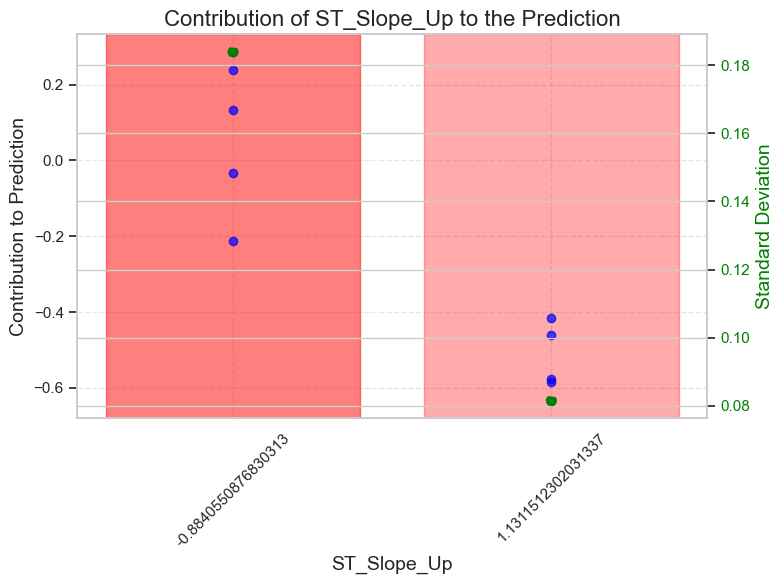

In [31]:
for i, feature_name in enumerate(feature_names):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    values = X_test[feature_name].dropna()

    if feature_name in numerical_columns:
        # Numerical Feature: Use KDE
        values_np = values.values
        kde = gaussian_kde(values_np)
        xs = torch.linspace(values_np.min(), values_np.max(), 200)
        density = kde(xs.numpy())
        density_norm = density / density.max()

        # Add shading
        bar_width = (xs[1] - xs[0]).item() * 10
        for x_val, shade in zip(xs, density_norm):
            ax1.axvspan(x_val.item(), x_val.item() + bar_width, color='red', alpha=0.07 * shade)

        # Plot NAM contributions
        xs_plot = xs
        all_ys = []
        for learner_ind in range(NUMBER_OF_LEARNERS):
            ys = model.models[learner_ind].feature_nns[i](xs_plot.unsqueeze(1)).detach().numpy().reshape(xs_plot.shape)
            all_ys.append(ys)
            ax1.plot(xs_plot, ys, c=sns.color_palette("Blues")[4], alpha=0.7)

    else:
        # Categorical Feature
        categories = values.unique()
        all_ys = []
        category_indices = torch.arange(len(categories)).float()

        # Dummy density based on value counts
        value_counts = values.value_counts(normalize=True)
        density = value_counts[categories].fillna(0).values
        density_norm = density / density.max()

        # Add shading for each category
        for j, (cat, shade) in enumerate(zip(categories, density_norm)):
            ax1.axvspan(j - 0.4, j + 0.4, color='red', alpha=0.5 * shade)

        # Evaluate model on each category (encoded)
        for learner_ind in range(NUMBER_OF_LEARNERS):
            # Encode category to one-hot or integer-based embedding index
            # Assume categories are passed through an embedding or ordinal encoder
            input_tensor = category_indices.unsqueeze(1)
            ys = model.models[learner_ind].feature_nns[i](input_tensor).detach().numpy().reshape(-1)
            all_ys.append(ys)
            ax1.scatter(category_indices, ys, c='blue', alpha=0.7)

        # Set xticks to category names
        ax1.set_xticks(category_indices)
        ax1.set_xticklabels(categories, rotation=45)

        xs_plot = category_indices

    ax1.set_title(f"Contribution of {feature_name} to the Prediction", fontsize=16)
    ax1.set_xlabel(f"{feature_name}", fontsize=14)
    ax1.set_ylabel("Contribution to Prediction", fontsize=14)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Standard deviation
    all_ys = np.stack(all_ys)
    std_ys = np.std(all_ys, axis=0)

    ax2 = ax1.twinx()
    if feature_name in numerical_columns:
        ax2.plot(xs_plot, std_ys, color='green', linestyle='--', linewidth=2, label='Std. Dev. Across Learners')
    else:
        ax2.scatter(xs_plot, std_ys, color='green', linestyle='--', linewidth=2, label='Std. Dev. Across Learners')
    ax2.set_ylabel("Standard Deviation", fontsize=14, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.tight_layout()
    plt.show()

In [11]:
print('----[TRAIN RESULTS]----')
pred = model.predict_proba(X)
print('F1 score:', sk_metrics.f1_score(y, pred > 0.5))
print('ROC AUC:', sk_metrics.roc_auc_score(y, pred))
print('----[TEST RESULTS]----')
pred = model.predict_proba(X_test)
print('F1 score:', sk_metrics.f1_score(y_test, pred > 0.5))
print('ROC AUC:', sk_metrics.roc_auc_score(y_test, pred))

----[TRAIN RESULTS]----
F1 score: 0.8935643564356436
ROC AUC: 0.9411417205072984
----[TEST RESULTS]----
F1 score: 0.8660714285714286
ROC AUC: 0.9055282555282556
